# Imports

In [2]:
#!/usr/bin/env python
# coding=utf-8
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

from nda import log
from nda.problems import LogisticRegression, RobustLinearRegression, NN
from nda.optimizers import GD, SGD
from nda.optimizers.utils import generate_mixing_matrix
from nda.experiment_utils import run_exp

from optimizers import CDP_SGD, SoteriaFL, LDP_SGD, LDP_SVRG, Q_DPSGD_1

import time

%matplotlib widget

In [3]:
def get_bits_per_round_per_agent(config, dim):
    res = dim * 64
    if 'compression' in config:
        if config['compression'] == 'unbiased_random_sparsification':
            res = config['compression_param'] * 64
        elif config['compression'] == 'random_quantization':
            res = config['compression_param'] * dim
    return res

In [4]:
def save_exp(results, configs, name, **kwargs):

    for res, config in zip(results, configs):
        data = res[1]
        data['t'] = data['t'].astype(int)
        data['n_grads'] = data['n_grads'].astype(int)
        if 'comm_rounds' in data:
            data['bits'] = get_bits_per_round_per_agent(config, p.dim) * p.n_agent * data.comm_rounds

    kwargs['results'] = results
    kwargs['configs'] = configs

    with open(f"data/{name}.pkl", 'wb') as f:
        pickle.dump(kwargs, f)

In [5]:
def plot_exp_final_final(results, name, save=False, legends=None):
    
    line_styles = [color + style for style in ['-', '--', ':'] for color in ['k', 'r', 'g', 'b', 'c', 'm', 'y']]

    legends = [_.replace('_', '-') for _ in legends]
    
    max_bits = min([_[1].bits.iloc[-1] for _ in results]) * 1.1
    max_iters = 1e10

    objs = [plt.subplots(1, 1, figsize=(4, 4)) for i in range(4)]
    figs = [_[0] for _ in objs]
    axs = [_[1] for _ in objs]

    def _plot(ax, x, y, x_max, xlabel='', ylabel=''):
        mask = x.values <= x_max
        ax.plot(
            x.values[mask],
            y.values[mask],
            style
        )
        ax.set(xlabel=xlabel, ylabel=ylabel)

    for i in range(len(results)):

        data = results[i][1]
        style = line_styles[i]

        _plot(axs[0], data.t, data.runnig_grad_norm, max_iters, xlabel='Communication rounds', ylabel='Utility')
        _plot(axs[1], data.t, data.f, max_iters, xlabel='Communication rounds', ylabel='Loss')

        _plot(axs[2], data.bits, data.runnig_grad_norm, max_bits, xlabel='Bits communicated', ylabel='Utility')
        _plot(axs[3], data.bits, data.f, max_bits, xlabel='Bits communicated', ylabel='Loss')

    return figs, axs

In [6]:
def run():

    exps = [LDP_SGD(p, **common_config, **config)
                   for config in LDP_SGD_configs] \
            + [LDP_SVRG(p, **common_config, **config)
                   for config in LDP_SVRG_configs] \
            + [CDP_SGD(p, **common_config, **config)
                   for config in CDP_SGD_configs] \
            + [SoteriaFL(p, **common_config, **config)
                   for config in SoteriaFL_configs]

    configs = LDP_SGD_configs + LDP_SVRG_configs + CDP_SGD_configs + SoteriaFL_configs

    for _ in configs:
        _.update(common_config)

    begin = time.time()
    if 'CUDA_VISIBLE_DEVICES' in os.environ:
        n_gpus = len(os.environ["CUDA_VISIBLE_DEVICES"].split(','))
        res = run_exp(exps, n_gpus=n_gpus, processes_per_gpu=2, plot=False)
    else:
        res = run_exp(exps, n_cpu_processes=4, plot=False)
    end = time.time()
    log.info('Total %.2fs', end - begin)

    return configs, res

# Logistic a9a

## eps = 5

In [7]:
n_agent = 10

np.random.seed(0)

p = LogisticRegression(n_agent=n_agent, dataset='a9a', sort=True,
                       normalize_data=False, graph_params=0.8, alpha=0.2)

dim = p.dim
x_0 = np.random.randn(dim) / 5

m = p.m
c = 48
print('p.m=', p.m)
print(p.X_train.shape, p.Y_train.shape)

n_iters = 100
np.random.seed(0)


common_config = {
    'n_iters': n_iters,
    'x_0': x_0.copy(),
    'extra_metrics': ['grad_norm', 'test_accuracy'],
    'early_stopping': False,
}

compression = {
    'compression': 'unbiased_random_sparsification',
    'compression_param': int(dim / 20)
}


G = 0.5

epsilon = 5
delta = 1e-3
omega = dim / compression['compression_param'] - 1

SGD_batch_size = min(int((m * epsilon * G * np.sqrt(np.sqrt((1 + omega) / n_agent) / 2)) / np.sqrt((1 + omega) * dim * (-np.log(delta)))), p.m)
SoteriaFL_batch_size = int((p.m ** (2/3)) / 4)
SoteriaFL_prob = SoteriaFL_batch_size / p.m

perturbation_variance_CDP_SGD = np.sqrt(8 * G**2 * n_iters * (-np.log(delta)) / (m**2 * epsilon**2))
perturbation_variance_SoteriaFL_SVRG = np.sqrt(96 * G**2 * n_iters * (-np.log(delta)) / (m**2 * epsilon**2))
perturbation_variance_SoteriaFL_SGD = np.sqrt(12 * G**2 * n_iters * (-np.log(delta)) / (m**2 * epsilon**2))

perturbation_variance_Q_DPSGD_1 = np.sqrt(16 * n_iters * (-2 * np.log(delta) / epsilon + 1) / (m**2 * epsilon))


gamma = np.sqrt((1 + 2 * omega) / (2 * ((1 + omega)**3)))

CDP_SGD_configs = [
    {'eta': 0.1, 'G': G, 'perturbation_variance': perturbation_variance_CDP_SGD, 'batch_size': SGD_batch_size, **compression},
]

SoteriaFL_configs = [
    {'eta': 0.3, 'gamma': gamma, 'local_update_method': 'svrg', 'G': G, 'perturbation_variance': perturbation_variance_SoteriaFL_SVRG, 'p_update_snapshot': SoteriaFL_prob, 'batch_size': SoteriaFL_batch_size, **compression},
    {'eta': 0.3, 'gamma': gamma, 'local_update_method': 'sgd', 'G': G, 'perturbation_variance': perturbation_variance_SoteriaFL_SGD, 'batch_size': SGD_batch_size, **compression},
]

LDP_SGD_configs = [
    {'eta': 1, 'G': G, 'perturbation_variance': perturbation_variance_CDP_SGD, 'batch_size': SGD_batch_size},
]

LDP_SVRG_configs = [
    {'eta': 1, 'G': G, 'perturbation_variance': perturbation_variance_SoteriaFL_SVRG, 'p_update_snapshot': SoteriaFL_prob, 'batch_size': SoteriaFL_batch_size},
]

configs, res = run()

INFO 23:00:58.8479 115716 dataset.py:32] Loading a9a dataset from cached file
INFO 23:00:59.1120 115716 logistic_regression.py:63] Initializing using GPU
INFO 23:00:59.8163 115827 logistic_regression.py:86] Computing norm
INFO 23:01:01.3349 115716 logistic_regression.py:79] Initialization done


p.m= 3256
(32560, 124) (32560,)


INFO 23:01:01.3621 116186 utils.py:21] LDP_SGD started
INFO 23:01:01.3820 116192 utils.py:21] LDP_SVRG started
INFO 23:01:01.4029 116195 utils.py:21] CDP_SGD started
INFO 23:01:01.4171 116198 utils.py:21] SoteriaFL-SVRG started
INFO 23:01:01.4418 116220 utils.py:21] SoteriaFL-SGD started
INFO 23:01:06.1686 116186 utils.py:40] LDP_SGD done, total 4.81s
INFO 23:01:07.1776 116195 utils.py:40] CDP_SGD done, total 5.77s
INFO 23:01:08.1333 116192 utils.py:40] LDP_SVRG done, total 6.75s
INFO 23:01:08.3242 116220 utils.py:40] SoteriaFL-SGD done, total 6.88s
INFO 23:01:08.4269 116198 utils.py:40] SoteriaFL-SVRG done, total 7.01s
INFO 23:01:08.7883 115716 890834466.py:24] Total 7.45s


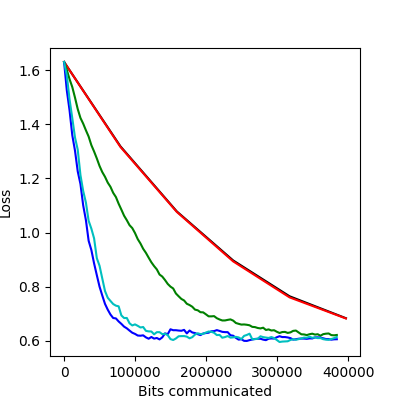

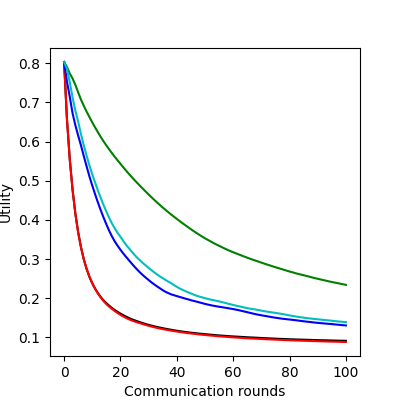

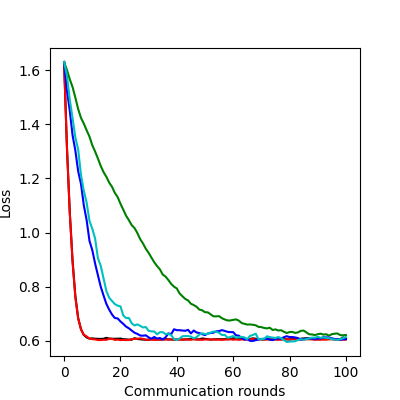

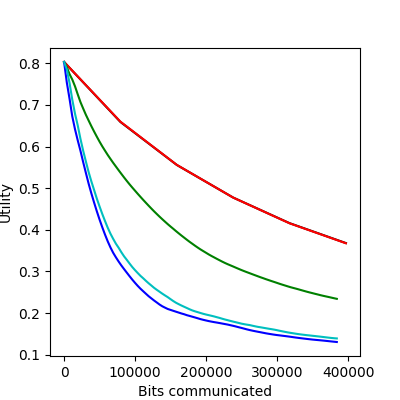

In [8]:
name = "a9a_logisticreg_eps_5"

for _, data in res:
    data['runnig_grad_norm'] = (data.grad_norm ** 2).cumsum() / (data.t + 1)

save_exp(res, configs, name, p=p, x_0=x_0)

legends = [_[0] for _, config in zip(res, configs)]
figs, axs = plot_exp_final_final(res, name, save=True, legends=legends)
plt.show()

## eps = 1

In [9]:
n_agent = 10

np.random.seed(0)

p = LogisticRegression(n_agent=n_agent, dataset='a9a', sort=True,
                       normalize_data=False, graph_params=0.8, alpha=0.2)

dim = p.dim
x_0 = np.random.randn(dim) / 5

m = p.m
c = 48
print('p.m=', p.m)
print(p.X_train.shape, p.Y_train.shape)

n_iters = 25
np.random.seed(0)


common_config = {
    'n_iters': n_iters,
    'x_0': x_0.copy(),
    'extra_metrics': ['grad_norm', 'test_accuracy'],
    'early_stopping': False,
}

compression = {
    'compression': 'unbiased_random_sparsification',
    'compression_param': int(dim / 20)
}


G = 0.5

epsilon = 1
delta = 1e-3
omega = dim / compression['compression_param'] - 1

SGD_batch_size = min(int((m * epsilon * G * np.sqrt(np.sqrt((1 + omega) / n_agent) / 2)) / np.sqrt((1 + omega) * dim * (-np.log(delta)))), p.m)
SoteriaFL_batch_size = int((p.m ** (2/3)) / 4)
SoteriaFL_prob = SoteriaFL_batch_size / p.m

perturbation_variance_CDP_SGD = np.sqrt(8 * G**2 * n_iters * (-np.log(delta)) / (m**2 * epsilon**2))
perturbation_variance_SoteriaFL_SVRG = np.sqrt(96 * G**2 * n_iters * (-np.log(delta)) / (m**2 * epsilon**2))
perturbation_variance_SoteriaFL_SGD = np.sqrt(12 * G**2 * n_iters * (-np.log(delta)) / (m**2 * epsilon**2))

perturbation_variance_Q_DPSGD_1 = np.sqrt(16 * n_iters * (-2 * np.log(delta) / epsilon + 1) / (m**2 * epsilon))

gamma = np.sqrt((1 + 2 * omega) / (2 * ((1 + omega)**3)))

CDP_SGD_configs = [
    {'eta': 0.6, 'G': G, 'perturbation_variance': perturbation_variance_CDP_SGD, 'batch_size': SGD_batch_size, **compression},
]

SoteriaFL_configs = [
    {'eta': 0.6, 'gamma': gamma, 'local_update_method': 'svrg', 'G': G, 'perturbation_variance': perturbation_variance_SoteriaFL_SVRG, 'p_update_snapshot': SoteriaFL_prob, 'batch_size': SoteriaFL_batch_size, **compression},
    {'eta': 0.6, 'gamma': gamma, 'local_update_method': 'sgd', 'G': G, 'perturbation_variance': perturbation_variance_SoteriaFL_SGD, 'batch_size': SGD_batch_size, **compression},
]

LDP_SGD_configs = [
    {'eta': 1, 'G': G, 'perturbation_variance': perturbation_variance_CDP_SGD, 'batch_size': SGD_batch_size},
]

LDP_SVRG_configs = [
    {'eta': 1, 'G': G, 'perturbation_variance': perturbation_variance_SoteriaFL_SVRG, 'p_update_snapshot': SoteriaFL_prob, 'batch_size': SoteriaFL_batch_size},
]

configs, res = run()

INFO 23:01:10.2317 115716 dataset.py:32] Loading a9a dataset from cached file
INFO 23:01:10.5159 115716 logistic_regression.py:63] Initializing using GPU
INFO 23:01:11.1698 116386 logistic_regression.py:86] Computing norm
INFO 23:01:12.8076 115716 logistic_regression.py:79] Initialization done


p.m= 3256
(32560, 124) (32560,)


INFO 23:01:12.8449 116394 utils.py:21] LDP_SGD started
INFO 23:01:12.8687 116397 utils.py:21] LDP_SVRG started
INFO 23:01:12.8926 116400 utils.py:21] CDP_SGD started
INFO 23:01:12.9206 116403 utils.py:21] SoteriaFL-SVRG started
INFO 23:01:12.9472 116407 utils.py:21] SoteriaFL-SGD started
INFO 23:01:17.2822 116394 utils.py:40] LDP_SGD done, total 4.44s
INFO 23:01:17.6221 116397 utils.py:40] LDP_SVRG done, total 4.75s
INFO 23:01:17.6604 116400 utils.py:40] CDP_SGD done, total 4.77s
INFO 23:01:17.6942 116407 utils.py:40] SoteriaFL-SGD done, total 4.75s
INFO 23:01:18.0011 116403 utils.py:40] SoteriaFL-SVRG done, total 5.08s
INFO 23:01:18.3236 115716 890834466.py:24] Total 5.51s


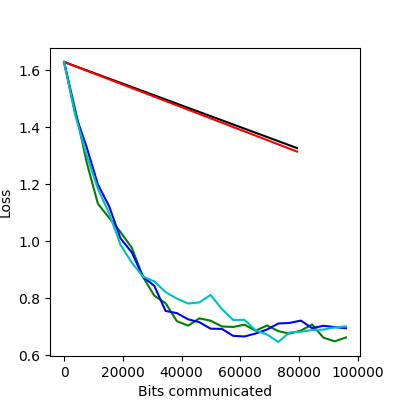

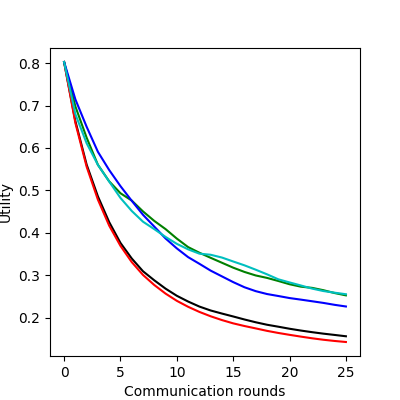

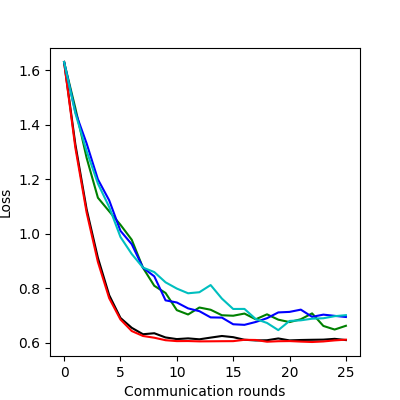

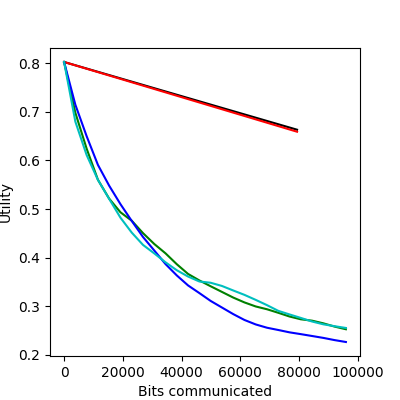

In [10]:
name = "a9a_logisticreg_eps_1"

for _, data in res:
    data['runnig_grad_norm'] = (data.grad_norm ** 2).cumsum() / (data.t + 1)

save_exp(res, configs, name, p=p, x_0=x_0)

legends = [_[0] for _, config in zip(res, configs)]
figs, axs = plot_exp_final_final(res, name, save=True, legends=legends)

plt.show()

## eps = 10

In [11]:
n_agent = 10

np.random.seed(0)

p = LogisticRegression(n_agent=n_agent, dataset='a9a', sort=True,
                       normalize_data=False, graph_params=0.8, alpha=0.2)

dim = p.dim
x_0 = np.random.randn(dim) / 5

m = p.m
c = 48
print('p.m=', p.m)
print(p.X_train.shape, p.Y_train.shape)

n_iters = 150
np.random.seed(0)


common_config = {
    'n_iters': n_iters,
    'x_0': x_0.copy(),
    'extra_metrics': ['grad_norm', 'test_accuracy'],
    'early_stopping': False,
}

compression = {
    'compression': 'unbiased_random_sparsification',
    'compression_param': int(dim / 20)
}


G = 0.5

epsilon = 10
delta = 1e-3
omega = dim / compression['compression_param'] - 1

SGD_batch_size = min(int((m * epsilon * G * np.sqrt(np.sqrt((1 + omega) / n_agent) / 2)) / np.sqrt((1 + omega) * dim * (-np.log(delta)))), p.m)
SoteriaFL_batch_size = int((p.m ** (2/3)) / 4)
SoteriaFL_prob = SoteriaFL_batch_size / p.m

perturbation_variance_CDP_SGD = np.sqrt(8 * G**2 * n_iters * (-np.log(delta)) / (m**2 * epsilon**2))
perturbation_variance_SoteriaFL_SVRG = np.sqrt(96 * G**2 * n_iters * (-np.log(delta)) / (m**2 * epsilon**2))
perturbation_variance_SoteriaFL_SGD = np.sqrt(12 * G**2 * n_iters * (-np.log(delta)) / (m**2 * epsilon**2))

gamma = np.sqrt((1 + 2 * omega) / (2 * ((1 + omega)**3)))

CDP_SGD_configs = [
    {'eta': 0.3, 'G': G, 'perturbation_variance': perturbation_variance_CDP_SGD, 'batch_size': SGD_batch_size, **compression},
]

SoteriaFL_configs = [
    {'eta': 0.6, 'gamma': gamma, 'local_update_method': 'svrg', 'G': G, 'perturbation_variance': perturbation_variance_SoteriaFL_SVRG, 'p_update_snapshot': SoteriaFL_prob, 'batch_size': SoteriaFL_batch_size, **compression},
    {'eta': 0.6, 'gamma': gamma, 'local_update_method': 'sgd', 'G': G, 'perturbation_variance': perturbation_variance_SoteriaFL_SGD, 'batch_size': SGD_batch_size, **compression},
]

LDP_SGD_configs = [
    {'eta': 1, 'G': G, 'perturbation_variance': perturbation_variance_CDP_SGD, 'batch_size': SGD_batch_size},
]

LDP_SVRG_configs = [
    {'eta': 1, 'G': G, 'perturbation_variance': perturbation_variance_SoteriaFL_SVRG, 'p_update_snapshot': SoteriaFL_prob, 'batch_size': SoteriaFL_batch_size},
]

configs, res = run()

INFO 23:01:19.2954 115716 dataset.py:32] Loading a9a dataset from cached file
INFO 23:01:19.5419 115716 logistic_regression.py:63] Initializing using GPU
INFO 23:01:20.0816 116470 logistic_regression.py:86] Computing norm
INFO 23:01:21.6685 115716 logistic_regression.py:79] Initialization done


p.m= 3256
(32560, 124) (32560,)


INFO 23:01:21.7137 116486 utils.py:21] LDP_SGD started
INFO 23:01:21.7806 116494 utils.py:21] CDP_SGD started
INFO 23:01:21.8105 116497 utils.py:21] SoteriaFL-SVRG started
INFO 23:01:21.7468 116489 utils.py:21] LDP_SVRG started
INFO 23:01:21.8549 116500 utils.py:21] SoteriaFL-SGD started
INFO 23:01:26.5205 116486 utils.py:40] LDP_SGD done, total 4.81s
INFO 23:01:27.4339 116494 utils.py:40] CDP_SGD done, total 5.65s
INFO 23:01:28.7989 116500 utils.py:40] SoteriaFL-SGD done, total 6.94s
INFO 23:01:28.8815 116497 utils.py:40] SoteriaFL-SVRG done, total 7.07s
INFO 23:01:29.1569 116489 utils.py:40] LDP_SVRG done, total 7.41s
INFO 23:01:29.7854 115716 890834466.py:24] Total 8.11s


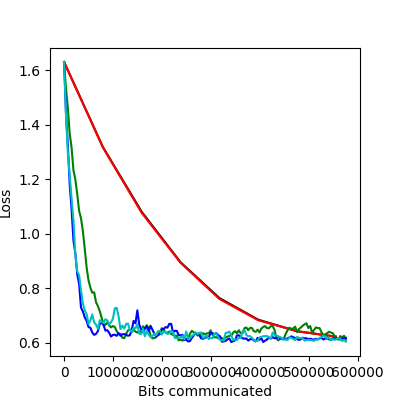

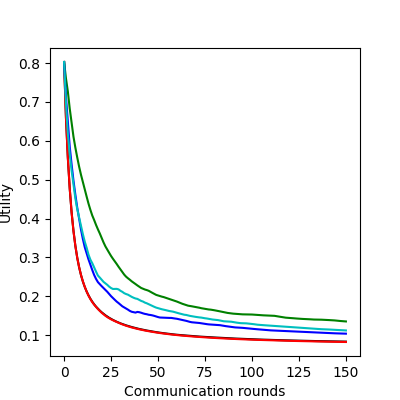

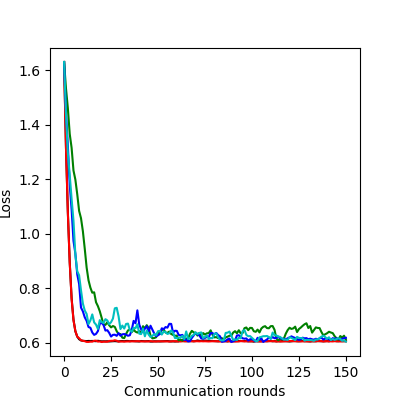

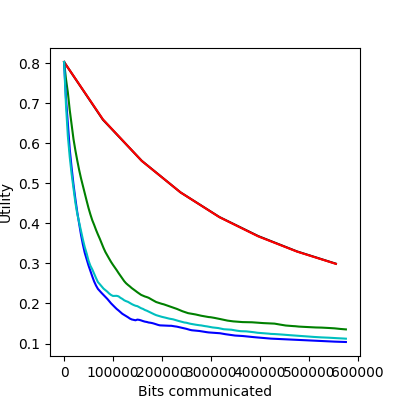

In [12]:
name = "a9a_logisticreg_eps_10"

for _, data in res:
    data['runnig_grad_norm'] = (data.grad_norm ** 2).cumsum() / (data.t + 1)

save_exp(res, configs, name, p=p, x_0=x_0)

legends = [_[0] for _, config in zip(res, configs)]
_ = plot_exp_final_final(res, name, save=True, legends=legends)
plt.show()